In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sensor_data_analysis import *

### 1. Data description

- Number of unique signals = 229
- Number of unique rooms = 253

**1a. Signal distribution based on BACnet types**

- BACnet: Building Automation and Control Network
- 8 different types of BACnet types
- Majority of them are Analog Input and analog Output

**1b. Signal distribution based on Building**

- Almost all the data is in EBU3B building

**1c. Signal distribution based on room**

- Room B102C and server room have highest number of signals

Number of unique signals =  229
Number of unique rooms =  253


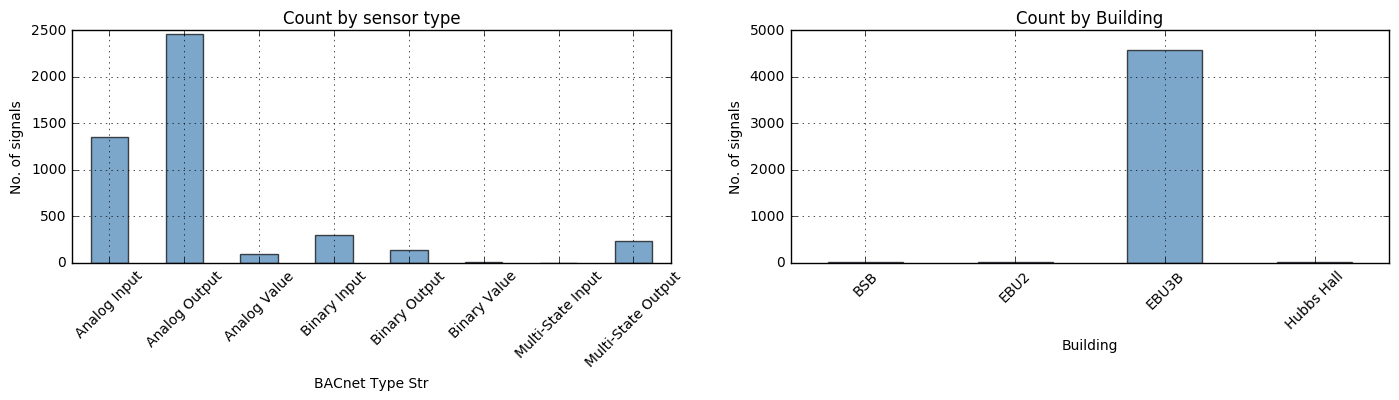

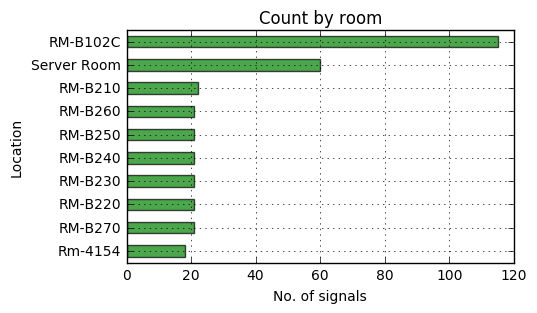

In [2]:
df_metadata = get_df_metadata()
print "Number of unique signals = ", df_metadata['Ground Truth Point Type'].nunique()
print "Number of unique rooms = ", df_metadata['Location'].nunique()

fig, axs = plt.subplots(1, 2, figsize=(17, 3))

df_metadata.groupby('BACnet Type Str')['BACnet Type Str'].count().plot(
    kind='bar', grid=True, alpha=0.7, color='steelblue', rot=45,
    title='Count by sensor type', ax=axs[0]);
axs[0].set(ylabel='No. of signals')

df_metadata.groupby('Building')['Building'].count().plot(
    kind='bar', grid=True, alpha=0.7, color='steelblue', rot=45,
    title='Count by Building', ax=axs[1])
axs[1].set(ylabel='No. of signals')

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
top10_df = df_metadata.groupby(['Location'])['Ground Truth Point Type'].nunique().sort_values(ascending=False).head(10)
top10_df.sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.7, grid=True,
                                                   legend=False, title='Count by room', ax=ax)
ax.set(xlabel='No. of signals');

### 2. Weather data

- Weather data for La Jolla is purchased from https://openweathermap.org/
![weather description](weather_metadata.png)

**2a. Weather data cleanup**

- Remove columns that have all / most nans
- Remove columns that are not applicable (city_id, weather_icon)

columns that are retained are:

1) dt_iso  
2) temp  
3) temp_min  
4) temp_max  
5) pressure  
6) humidity  
7) wind_speed  
8) wind_deg  
9) clouds_all  
10) weather_id  
11) weather_main

**2b. Feature engineering**

1) Conversion of temperature columns from Klevin to farenheit  
2) Label encoding for weather_main

In [3]:
weather_df = get_df_weather()
weather_df.head(3)

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,date,hour
0,2012-10-01 06:00:00,65.318,62.006,75.992,1013,59,1,60,1,800,0,2012-10-01,6
1,2012-10-01 07:00:00,64.940,60.008,78.008,1013,55,0,0,3,721,4,2012-10-01,7
2,2012-10-02 08:00:00,69.422,60.800,82.004,1014,56,1,340,3,721,4,2012-10-02,8


### 3. Understanding the signal data

- Zone temperature for each day (monday - sunday) for Room 3114 accross years is plotted.
- This is to see the high level behavior / variance.

**Observations**

- Weekend's behavior is different than week day as expected.
- Saturday and Sunday has higher zone temperature values in summers than in winters as expected.
- Zone temperature for week days is almost uniform accross summers and winters probably due to air conditioning.

**conclusion**

- Week day is very important factor and is worth modelling separately for each day of week.

Read file:  506_0_3003116.csv


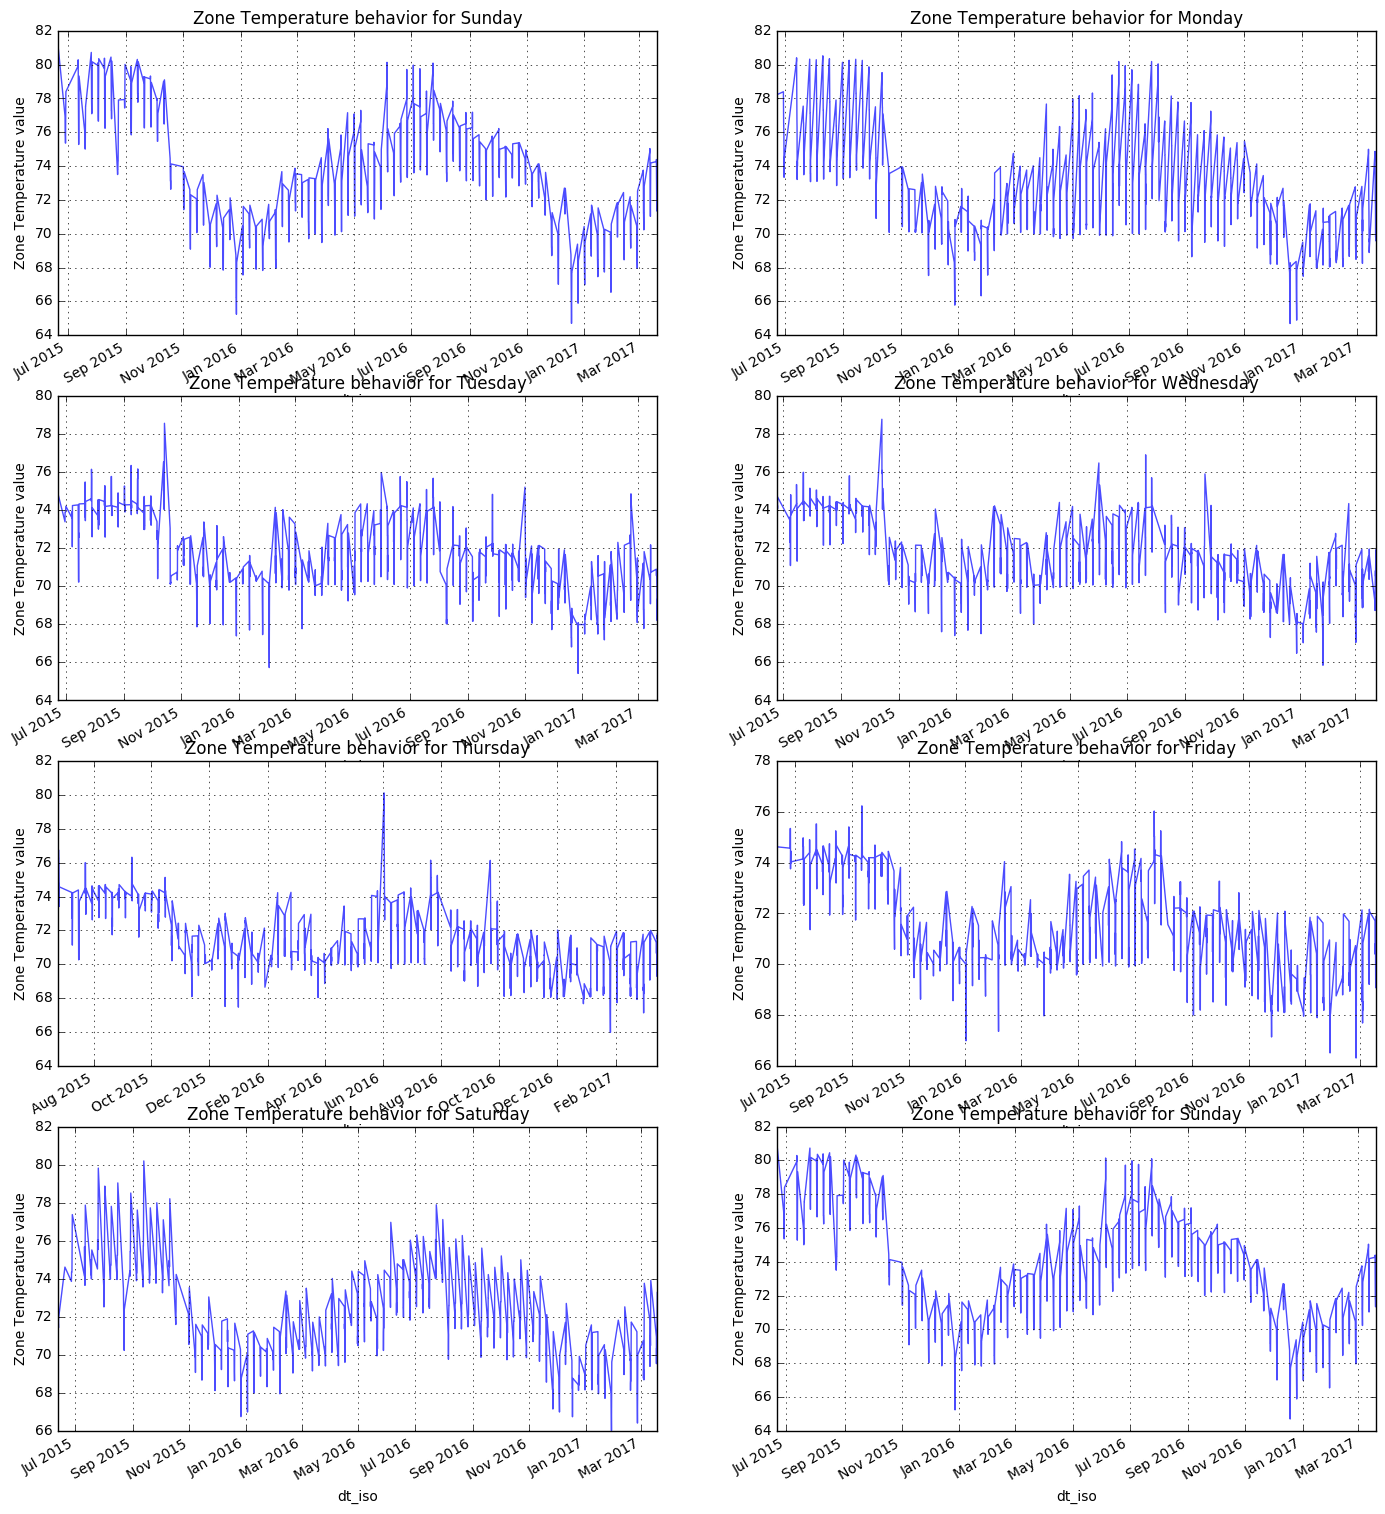

In [4]:
room = 'Rm-3114'
signals= ["Zone Temperature"]
model_df = get_signal_dataframe(room, signals)

# Filter the data from june 2015
model_filtered = model_df[model_df.dt_iso > pd.to_datetime("2015-06-01")]

fig, axs = plt.subplots(4, 2, figsize=(17, 20))

def plot_graph(model_filtered, ax, day, signal):
    model_filtered[model_filtered.dt_iso.dt.weekday_name == day].set_index('dt_iso')[['Zone Temperature']].plot(
        grid=True, alpha=0.7, ax=ax, legend=False)
    ax.set_title(signal + " behavior for " + day)
    ax.set(ylabel = signal + " value")

plot_graph(model_filtered, axs[0][0], "Sunday", "Zone Temperature")
plot_graph(model_filtered, axs[0][1], "Monday", "Zone Temperature")
plot_graph(model_filtered, axs[1][0], "Tuesday", "Zone Temperature")
plot_graph(model_filtered, axs[1][1], "Wednesday", "Zone Temperature")
plot_graph(model_filtered, axs[2][0], "Thursday", "Zone Temperature")
plot_graph(model_filtered, axs[2][1], "Friday", "Zone Temperature")
plot_graph(model_filtered, axs[3][0], "Saturday", "Zone Temperature")
plot_graph(model_filtered, axs[3][1], "Sunday", "Zone Temperature")

### 4. Modelling for Zone temperature

**What:** Model the room 3114 for each week day based on external weather parameters. Predict the Zone temperature value based on weather features.

**Procedure:**

- Get the Zone temperature data for room 3114 (zone temperature is recorded every 5 minutes)  
- Create the hour feature from datetime field.  
- Average the Zone temperature value within each hour (This is needed because weather data is for each hour)  
- Merge the signal data with weather data (features for model) on date time field (This is inner join and so we may loose some data).  
- Filter the data for a specific day of week (Ex:- Sunday)
- Split the data into training and testing set (66% training, 33% testing)  
- Train the data (weather data columns are features and zone temperature is target variable) using various models (ridge, Lasso, AdaBoostRegressor, DecisionTreeRegressor)
- Predict the zone temperature on the testing set.
- Print the scores (coefficient of determination R^2 of the prediction) with various models for training and testing.

**Results**

- DecisionTreeRegressor performs best on training data (not surprised)
- AdaBootRegressor performs well on testing data.

In [5]:
room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour']
day = "Sunday"
target = "Zone Temperature"

model_df = get_signal_dataframe(room, signals)
model_for_day(model_df, features, target)

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv


,model,test score,train score
0,DecisionTreeRegressor,0.748442,1.000000
1,LinearRegression,0.703811,0.691586
2,Lasso,0.703173,0.684132
3,Ridge,0.703820,0.691586
4,AdaBoostRegressor,0.756906,0.770325


### 5. Modelling for Supply airflow

**What:** Model the room 3114 for each week day based on external weather parameters. Predict the Supply airflow value based on weather features and zone temperature.

**Procedure:**

- Followed the same procedure as above (for zone temperature). (Weather data as features and supply airflow as target variable)
- The model score is very bad with the weather only features.
- Used zone temperature as feature along with weather data and predicted the supply airflow.
- Got better scores (But should be improved).
- Zone temperature is very important in deciding the supply airflow.

**Results**

- DecisionTreeRegressor performs best on training data (not surprised)
- AdaBootRegressor performs well on testing data.

In [6]:
room = 'Rm-3114'
signals = ["Zone Temperature", 'Supply Airflow']
features = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
        'clouds_all', 'weather_id', 'weather_main', 'hour', "Zone Temperature"]
day = "Sunday"
target = 'Supply Airflow'

model_df = get_signal_dataframe(room, signals)
model_for_day(model_df, features, target)

Read file:  506_0_3003116.csv
Read file:  506_0_3003122.csv


,model,test score,train score
0,DecisionTreeRegressor,0.450660,1.000000
1,LinearRegression,0.112775,0.132351
2,Lasso,0.114778,0.131168
3,Ridge,0.112779,0.132351
4,AdaBoostRegressor,0.450523,0.716025
